<a href="https://colab.research.google.com/github/CelikAbdullah/my-deep-learning-notebooks/blob/main/generative%20adversarial%20networks/Generating_MNIST_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [7]:
from tensorflow import keras
import numpy as np
import tensorflow as tf
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt

# Get the MNIST data

In [ ]:
(x_train, _), _ = keras.datasets.mnist.load_data()

In [ ]:
x_train = x_train.astype("float32") / 255
x_train.shape

(60000, 28, 28)

In [ ]:
x_train = np.expand_dims(x_train, -1)

In [ ]:
x_train.shape

(60000, 28, 28, 1)

# Discriminator model

In [ ]:
discriminator = keras.Sequential(
    [
     keras.Input(shape=(28,28,1)), 
     keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"), 
     keras.layers.LeakyReLU(alpha=0.2),
     keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"), 
     keras.layers.LeakyReLU(alpha=0.2), 
     keras.layers.Flatten(), 
     keras.layers.Dropout(0.2), 
     keras.layers.Dense(1, activation="sigmoid"), 
    ], name="discriminator_model"
)

discriminator.summary()

Model: "discriminator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        1088      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_1 (Dropout)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 1)         

# Generator model

In [ ]:
latent_dimension = 128

generator = keras.Sequential(
    [
     keras.Input(shape=(latent_dimension, )), 
     keras.layers.Dense(7 * 7 * 128), 
     keras.layers.Reshape((7, 7, 128)), 
     keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
     keras.layers.LeakyReLU(alpha=0.2),
     keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
     keras.layers.LeakyReLU(alpha=0.2),
     keras.layers.Conv2D(1, kernel_size=5, padding="same", activation="sigmoid"),
    ]
)

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              809088    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 28, 28, 256)      

# GAN model

In [ ]:
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super().__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")
    
  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    
  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]
    
  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    generated_images = self.generator(random_latent_vectors)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],axis=0)
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
      
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    misleading_labels = tf.zeros((batch_size, 1))
      
    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)
      
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {"d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()}

# Define a custom callback

In [ ]:
# a callback that samples generated images during training
class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim
    
  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()

    for i in range(self.num_img):
      img = keras.utils.array_to_img(generated_images[i])
      img.save(f"generated_img_{epoch:03d}_{i}.png")


# Create the GAN model

In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dimension)

# Compile and train the GAN model

In [ ]:
epochs = 100

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    x_train, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dimension)]
)

Epoch 1/100
1875/1875 [==============================] - 44s 23ms/step - d_loss: 0.5503 - g_loss: 1.0371
Epoch 2/100
1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6089 - g_loss: 1.0318
Epoch 3/100
1875/1875 [==============================] - 42s 23ms/step - d_loss: 0.5806 - g_loss: 1.0619
Epoch 4/100
1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6425 - g_loss: 0.8896
Epoch 5/100
1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6404 - g_loss: 0.8873
Epoch 6/100
1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6319 - g_loss: 0.9028
Epoch 7/100
1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6281 - g_loss: 0.9199
Epoch 8/100
1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6256 - g_loss: 0.9042
Epoch 9/100
1875/1875 [==============================] - 41s 22ms/step - d_loss: 0.6240 - g_loss: 0.9226
Epoch 10/100
1875/1875 [==============================]

KeyboardInterrupt: ignored

I stopped training the GAN after 62 epochs.

# Printing the generated images

## The results after the first epoch

<Figure size 432x288 with 0 Axes>

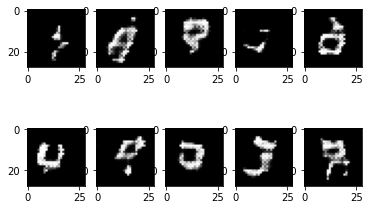

In [15]:
img0 = Image.open('/content/generated_img_000_0.png')
img1 = Image.open('/content/generated_img_000_1.png')
img2 = Image.open('/content/generated_img_000_2.png')
img3 = Image.open('/content/generated_img_000_3.png')
img4 = Image.open('/content/generated_img_000_4.png')
img5 = Image.open('/content/generated_img_000_5.png')
img6 = Image.open('/content/generated_img_000_6.png')
img7 = Image.open('/content/generated_img_000_7.png')
img8 = Image.open('/content/generated_img_000_8.png')
img9 = Image.open('/content/generated_img_000_9.png')

numpyImg0 = asarray(img0)
numpyImg1 = asarray(img1)
numpyImg2= asarray(img2)
numpyImg3= asarray(img3)
numpyImg4= asarray(img4)
numpyImg5= asarray(img5)
numpyImg6= asarray(img6)
numpyImg7= asarray(img7)
numpyImg8= asarray(img8)
numpyImg9= asarray(img9)
plt.figure()
f, axarr = plt.subplots(2,5) 
axarr[0][0].imshow(numpyImg0, cmap="gray")
axarr[0][1].imshow(numpyImg1, cmap="gray")
axarr[0][2].imshow(numpyImg2, cmap="gray")
axarr[0][3].imshow(numpyImg3, cmap="gray")
axarr[0][4].imshow(numpyImg4, cmap="gray")

axarr[1][0].imshow(numpyImg5, cmap="gray")
axarr[1][1].imshow(numpyImg6, cmap="gray")
axarr[1][2].imshow(numpyImg7, cmap="gray")
axarr[1][3].imshow(numpyImg8, cmap="gray")
axarr[1][4].imshow(numpyImg9, cmap="gray")


# The results after the 31th epoch

<Figure size 432x288 with 0 Axes>

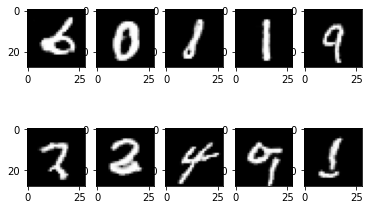

In [16]:
img0 = Image.open('/content/generated_img_031_0.png')
img1 = Image.open('/content/generated_img_031_1.png')
img2 = Image.open('/content/generated_img_031_2.png')
img3 = Image.open('/content/generated_img_031_3.png')
img4 = Image.open('/content/generated_img_031_4.png')
img5 = Image.open('/content/generated_img_031_5.png')
img6 = Image.open('/content/generated_img_031_6.png')
img7 = Image.open('/content/generated_img_031_7.png')
img8 = Image.open('/content/generated_img_031_8.png')
img9 = Image.open('/content/generated_img_031_9.png')

numpyImg0 = asarray(img0)
numpyImg1 = asarray(img1)
numpyImg2= asarray(img2)
numpyImg3= asarray(img3)
numpyImg4= asarray(img4)
numpyImg5= asarray(img5)
numpyImg6= asarray(img6)
numpyImg7= asarray(img7)
numpyImg8= asarray(img8)
numpyImg9= asarray(img9)
plt.figure()
f, axarr = plt.subplots(2,5) 
axarr[0][0].imshow(numpyImg0, cmap="gray")
axarr[0][1].imshow(numpyImg1, cmap="gray")
axarr[0][2].imshow(numpyImg2, cmap="gray")
axarr[0][3].imshow(numpyImg3, cmap="gray")
axarr[0][4].imshow(numpyImg4, cmap="gray")

axarr[1][0].imshow(numpyImg5, cmap="gray")
axarr[1][1].imshow(numpyImg6, cmap="gray")
axarr[1][2].imshow(numpyImg7, cmap="gray")
axarr[1][3].imshow(numpyImg8, cmap="gray")
axarr[1][4].imshow(numpyImg9, cmap="gray")

# The results after the 61th epoch

<Figure size 432x288 with 0 Axes>

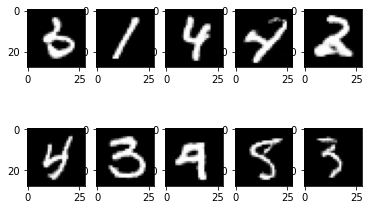

In [17]:
img0 = Image.open('/content/generated_img_061_0.png')
img1 = Image.open('/content/generated_img_061_1.png')
img2 = Image.open('/content/generated_img_061_2.png')
img3 = Image.open('/content/generated_img_061_3.png')
img4 = Image.open('/content/generated_img_061_4.png')
img5 = Image.open('/content/generated_img_061_5.png')
img6 = Image.open('/content/generated_img_061_6.png')
img7 = Image.open('/content/generated_img_061_7.png')
img8 = Image.open('/content/generated_img_061_8.png')
img9 = Image.open('/content/generated_img_061_9.png')

numpyImg0 = asarray(img0)
numpyImg1 = asarray(img1)
numpyImg2= asarray(img2)
numpyImg3= asarray(img3)
numpyImg4= asarray(img4)
numpyImg5= asarray(img5)
numpyImg6= asarray(img6)
numpyImg7= asarray(img7)
numpyImg8= asarray(img8)
numpyImg9= asarray(img9)
plt.figure()
f, axarr = plt.subplots(2,5) 
axarr[0][0].imshow(numpyImg0, cmap="gray")
axarr[0][1].imshow(numpyImg1, cmap="gray")
axarr[0][2].imshow(numpyImg2, cmap="gray")
axarr[0][3].imshow(numpyImg3, cmap="gray")
axarr[0][4].imshow(numpyImg4, cmap="gray")

axarr[1][0].imshow(numpyImg5, cmap="gray")
axarr[1][1].imshow(numpyImg6, cmap="gray")
axarr[1][2].imshow(numpyImg7, cmap="gray")
axarr[1][3].imshow(numpyImg8, cmap="gray")
axarr[1][4].imshow(numpyImg9, cmap="gray")